In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D,Activation
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Sequential, Model
%matplotlib inline

In [2]:
im_shape = (300,300)
seed = 10
BATCH_SIZE = 32

train_dir = r"C:\Users\25690\Downloads\archive\train"
test_dir = r'C:\Users\25690\Downloads\archive\test'
val_dir = r'C:\Users\25690\Downloads\archive\val'

In [3]:
data_generator = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [4]:
# generate train data
train_generator = data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# generate validation data
validation_generator = val_data_generator.flow_from_directory(val_dir, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# generate test data
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('classes: '+str(classes))
num_classes = len(classes)

Found 5061 images belonging to 4 classes.
Found 6 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [5]:
modelcnn = Sequential()
#add layers of CNN
modelcnn.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(im_shape[0],im_shape[1],3)))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Dropout(0.2))
modelcnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Flatten())
modelcnn.add(Dense(100, activation='relu'))
modelcnn.add(Dropout(0.2))
modelcnn.add(Dense(num_classes, activation='softmax'))
#see summary of the CNN model
modelcnn.summary()
#compile cnn and set metrics to recall
modelcnn.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=[tf.keras.metrics.Recall()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        1

In [6]:
epochs = 10

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modelcnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1)
]

#the training process
history = modelcnn.fit(train_generator, steps_per_epoch=nb_train_samples // BATCH_SIZE, epochs=epochs,
        callbacks = callbacks_list, validation_data=validation_generator, verbose = 1,
                       validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
158/158 [==============================] - 49s 273ms/step - loss: 0.4327 - recall: 0.8238
Epoch 2/10
158/158 [==============================] - 43s 273ms/step - loss: 0.1793 - recall: 0.9328
Epoch 3/10
158/158 [==============================] - 42s 266ms/step - loss: 0.1171 - recall: 0.9586
Epoch 4/10
158/158 [==============================] - 41s 261ms/step - loss: 0.0877 - recall: 0.9678
Epoch 5/10
158/158 [==============================] - 42s 264ms/step - loss: 0.0632 - recall: 0.9773
Epoch 6/10
158/158 [==============================] - 43s 270ms/step - loss: 0.0479 - recall: 0.9829
Epoch 7/10
158/158 [==============================] - 41s 258ms/step - loss: 0.0334 - recall: 0.9881
Epoch 8/10
158/158 [==============================] - 43s 274ms/step - loss: 0.0293 - recall: 0.9885
Epoch 9/10
158/158 [==============================] - 43s 271ms/step - loss: 0.0470 - recall: 0.9843
Epoch 10/10
158/158 [==============================] - 41s 258ms/step - loss: 0.0255 - reca

In [7]:
val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [8]:
# Load the best saved model
from tensorflow.keras.models import load_model

score = modelcnn.evaluate_generator(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\n\nval loss:', score[0])
print('val accuracy:', score[1])

score = modelcnn.evaluate_generator(test_generator)
print('\ntest loss:', score[0])
print('test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])



val loss: 1.0211967492068652e-05
val accuracy: 1.0

test loss: 1.3227849006652832
test accuracy: 0.8041504621505737


In [9]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.around(cm_norm, decimals=2)
        cm_norm[np.isnan(cm_norm)] = 0.0
        cm = cm_norm

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()
    plt.show()

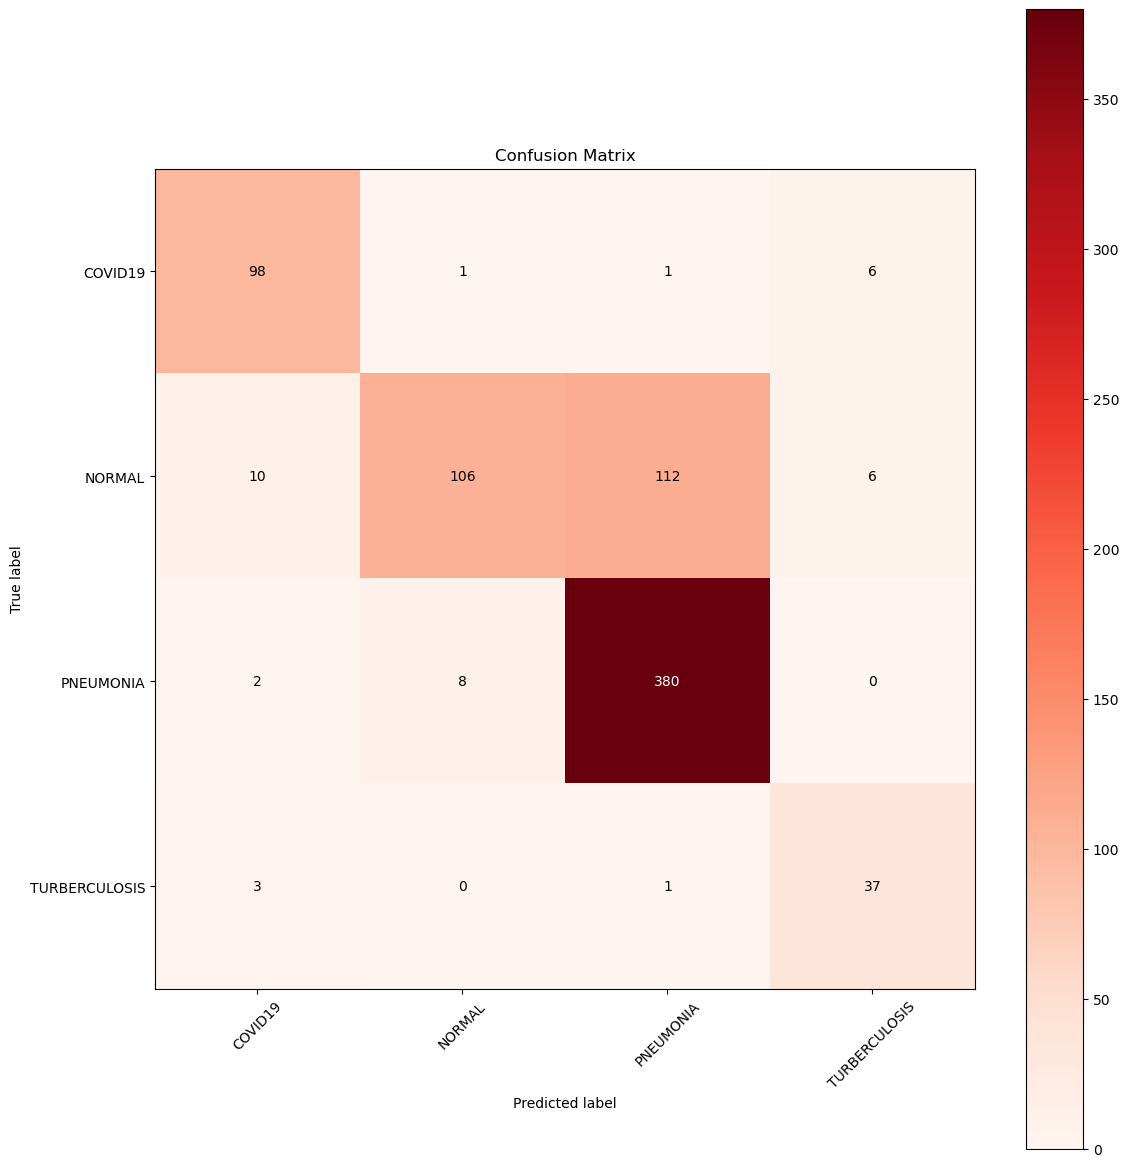

Classification Results
               precision    recall  f1-score   support

      COVID19       0.87      0.92      0.89       106
       NORMAL       0.92      0.45      0.61       234
    PNEUMONIA       0.77      0.97      0.86       390
TURBERCULOSIS       0.76      0.90      0.82        41

     accuracy                           0.81       771
    macro avg       0.83      0.81      0.80       771
 weighted avg       0.83      0.81      0.79       771



In [10]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = modelcnn.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Results')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))